# TODO 

Cross Validation - Backtesting : https://www.youtube.com/watch?v=1O_BenficgE&t=75s&ab_channel=Dataquest 

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
sns.set_theme(color_codes=True)

import pickle
import joblib
import json
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "BDay")

import sys
import os
# Get the current directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)


In [2]:
from src.utils.util import DotDict

with open(parent_dir+'/train/config.json', 'r') as config_file:
    config = DotDict(**json.load(config_file))

etl_version = config.etl_version
with open(f'{parent_dir}/etl/metadata/metadata_v{etl_version}.json', 'r') as metadata:
    etl_metadata = DotDict(**json.load(metadata))

In [3]:
%load_ext autoreload
%autoreload 2

from src.utils.model_functions import (compute_evaluation_metrics, 
                       compute_prediction_intervals,
                       interpolate_prediction_days)
from utils.visualization_functions import plot_prediction_errors

from src.services import splitterclass
from src.services.aggregatorclass import FeatureAggregator


# Data Reading

In [4]:
ds_data = joblib.load(f'../data/processed/{etl_metadata.output_processed}')

# Splitting datasets

In [5]:
splitter = splitterclass.DataSplitter(ds_data)
ds_train, ds_test, ds_eval, ds_forecast = splitter.split_datasets(ds_data)

print(f' Train start : {ds_train.index[0]} , end : {ds_train.index[-1]}')
print(f' Test start : {ds_test.index[0]} , end : {ds_test.index[-1]}')
print(f' Eval start : {ds_eval.index[0]} , end : {ds_eval.index[-1]}')
print(f' Forecast day start : {ds_forecast.index[0]} , end : {ds_forecast.index[-1]}')

 Train start : 2007-09-13 00:00:00 , end : 2023-06-05 00:00:00
 Test start : 2023-06-06 00:00:00 , end : 2023-09-07 00:00:00
 Eval start : 2023-09-08 00:00:00 , end : 2023-10-09 00:00:00
 Forecast day start : 2023-10-10 00:00:00 , end : 2023-10-10 00:00:00


In [6]:
# Chequeo de nulls
ds_eval.columns[ds_eval.isna().any()]
ds_eval.columns[ (ds_eval.isna().sum() * 100 / ds_eval.shape[0]) > 0 ]


Index(['target_5d', 'target_10d', 'target_23d'], dtype='object')

In [7]:
# Null Check on forecast row
ds_forecast.columns[ (ds_forecast.isna().sum() * 100 / ds_forecast.shape[0]) > 0 ]

Index(['target_1d', 'target_5d', 'target_10d', 'target_23d'], dtype='object')

In [8]:
# Null Check on Training row
ds_train.columns[ (ds_train.isna().sum() * 100 / ds_train.shape[0]) > 0 ]

Index([], dtype='object')

# Training XGBoost

In [9]:
grid_search_period = False
train_test_perdiod = False & ~grid_search_period

target = etl_metadata.target
on_columns = config.features.on_columns
windows = config.features.day_windows

In [30]:
y_train = ds_train[target]
y_test = ds_test[target]
y_eval = ds_eval[target]

ct = ColumnTransformer([("selector", "passthrough", on_columns)],
                       verbose_feature_names_out = False,             
                       remainder="drop").set_output(transform='pandas')

if grid_search_period :
    
    param_grid = {
        #'eta': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 300], #      
        'max_depth': [3, 5, 7],
        'lambda': [1],
        'min_child_weight': [1, 2, 3]
    }  
    tscv = TimeSeriesSplit(n_splits=2, test_size=23)
    
    model = xgb.XGBRegressor(#n_estimators=5000, 
                             #max_depth=7, 
                             eta=0.1, 
                             objective='reg:squarederror' , 
                             random_state=42)       
    
    
    pipeline = Pipeline([
        ("selector", ct),
        ('aggregator', FeatureAggregator(on_columns, windows)),
        ('scaler', StandardScaler())
    ])  

    X_train = pipeline.fit_transform(ds_train)
    X_test = pipeline.transform(ds_test)

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose = 4)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)    
    pipeline = grid_search
    
#    
elif train_test_perdiod:
    
    model = xgb.XGBRegressor(
        n_estimators=27,
        max_depth=4,  
        min_child_weight=1,
        eta=0.1, 
        reg_lambda=0,
        objective='reg:squarederror',
        early_stopping_rounds=3,
        eval_metric='rmse', 
        random_state=42) 
    
    pipeline = Pipeline([
        ("selector", ct),
        ('aggregator', FeatureAggregator(on_columns, windows)),        
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    X_train = pipeline[0:3].fit_transform(ds_train)
    X_test = pipeline[0:3].transform(ds_test)    

    pipeline.fit(ds_train, y_train, 
                 model__eval_set = [ (X_train, y_train), (X_test, y_test) ],
                 model__verbose = 10 ) 
else: 
    
# Best Hyperparameters: {'lambda': 1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50}

    model = xgb.XGBRegressor(
        n_estimators=27,
        max_depth=4,  
        min_child_weight=1,
        eta=0.1, 
        reg_lambda=0,
        objective='reg:squarederror',
        random_state=42)  
    
    pipeline = Pipeline([
        ("selector", ct),
        ('aggregator', FeatureAggregator(on_columns, windows)),        
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    X_train_c = pd.concat([ds_train, ds_test], axis=0)
    y_train_c = pd.concat([y_train, y_test], axis=0)   
    pipeline.fit(X_train_c, y_train_c , model__verbose = 10 ) 

In [31]:
#Best Hyperparameters: {'lambda': 1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50}

y_pred_train = pipeline.predict(ds_train)
y_pred_test = pipeline.predict(ds_test)


In [33]:

ds_metrics = compute_evaluation_metrics(y_pred_train, y_train, 'train_metrics')
ds_metrics = pd.concat( [ ds_metrics, compute_evaluation_metrics(y_pred_test, y_test, 'test_metrics')] , axis = 1)
ds_metrics

,train_metrics,test_metrics
MAE,28.63,101.92
MAPE,0.15,0.09
MSE,1928.60,18392.03
RMSE,43.92,135.62
R^2,0.99,-0.52


In [14]:
#pickle.dump(xgb_pipeline, open("xgb_pipeline_MELI_10-15.dat", "wb"))

## XGBoost feature importance

Text(0.5, 1.0, 'XGBoost Feature Importance')

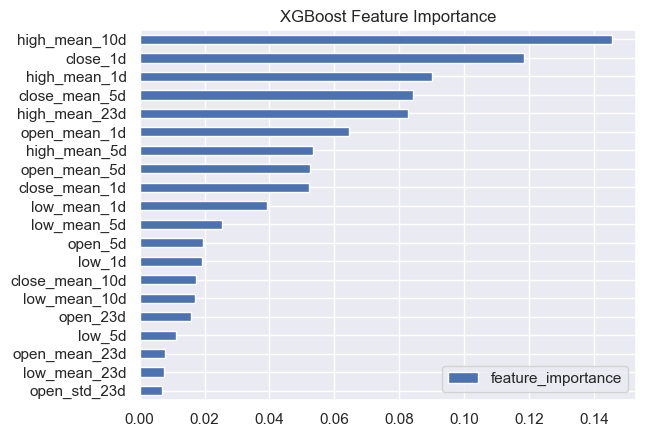

In [35]:
fi = pd.DataFrame(data = pipeline['model'].feature_importances_ , index = pipeline['aggregator'].agg_features_, columns = ['feature_importance'])
ax = fi.sort_values('feature_importance', ascending = True).tail(20).plot(kind = 'barh')
ax.set_title('XGBoost Feature Importance')

# Evaluating Train Period

In [16]:
## Calculate predictions and predictions intervals 

targets_day_periods = [1,5,10, 23]
y_pred_train = pipeline.predict(ds_train)

pred_cols=  [f'pred_{t}d' for t in targets_day_periods ]

ds_train_pred = ds_train.merge( pd.DataFrame(y_pred_train, columns=pred_cols, index = ds_train.index) , how = 'left', left_index = True, right_index= True )  

#for period in targets_day_periods:
#    ds_train_pred = pd.concat([ds_train_pred, compute_prediction_intervals(ds_train_pred[f'pred_{period}d'], ds_train_pred[f'target_{period}d'])  ], axis = 1)


,train_pred_1d,train_pred_5d,train_pred_10d,train_pred_23d
MAE,22.30,27.45,29.89,34.86
MAPE,0.15,0.15,0.16,0.16
MSE,869.90,1669.95,2070.39,3104.16
RMSE,29.49,40.87,45.50,55.71
R^2,1.00,0.99,0.99,0.98


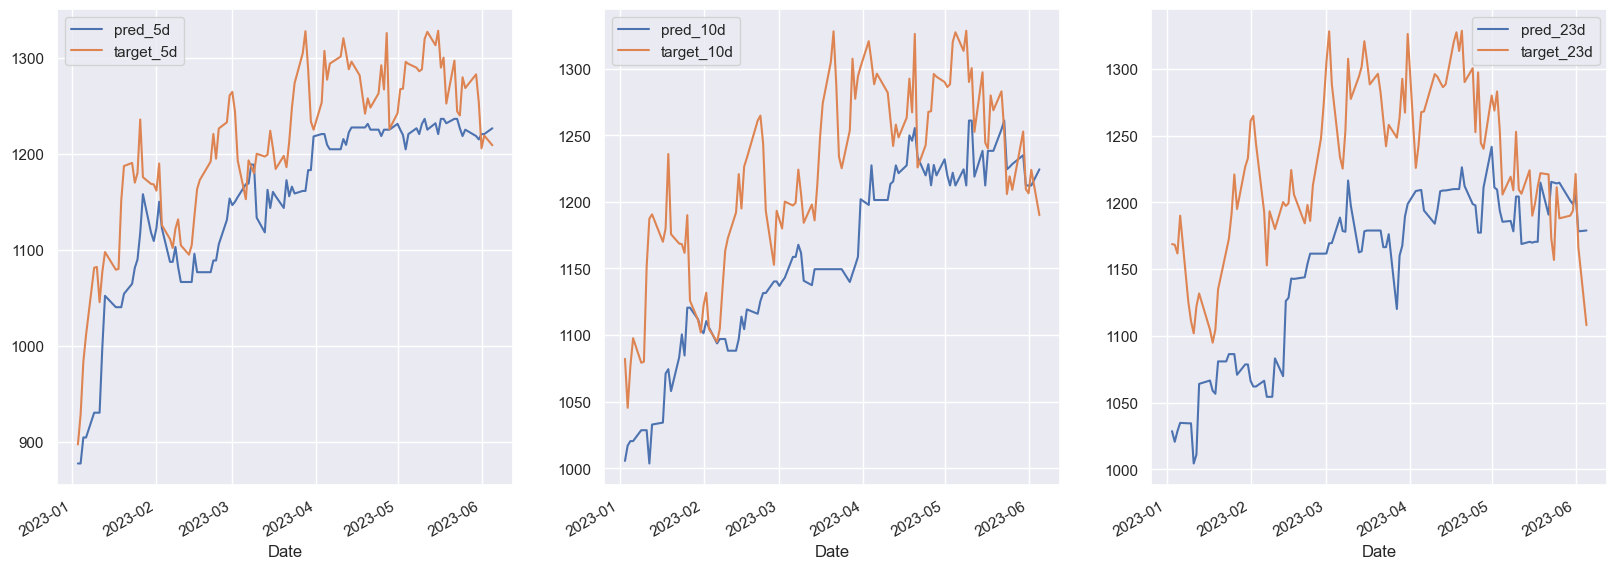

In [17]:
ds_metrics = compute_evaluation_metrics(ds_train_pred['pred_1d'], ds_train_pred['target_1d'], 'train_pred_1d')

fix, axs = plt.subplots( 1,3 , figsize = (20,7))
for idx, pred_col ,target_col in [ (0, 'pred_5d' , 'target_5d'), (1, 'pred_10d', 'target_10d')   ,(2,'pred_23d', 'target_23d') ]:
    
    ds_train_pred['2023-01-01':][[ pred_col , target_col ]].plot(ax = axs[idx] )
    ds_metrics = pd.concat( [ ds_metrics, compute_evaluation_metrics(ds_train_pred[pred_col], ds_train_pred[target_col], f'train_{pred_col}')] , axis = 1)
    
display(ds_metrics)


### Forecast 23 days from 2023-05-03

In [18]:
day_periods = config.train.forecast_days

dt_train_forecast_idx = pd.bdate_range(start=ds_train.iloc[ -23: -22 ][target].index[0], periods=day_periods, freq='B') 
ds_pred_interpolate = interpolate_prediction_days(y_pred_train[-23:-22], dt_train_forecast_idx, targets_day_periods)

/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1495: FutureWarning: Per

<Axes: >

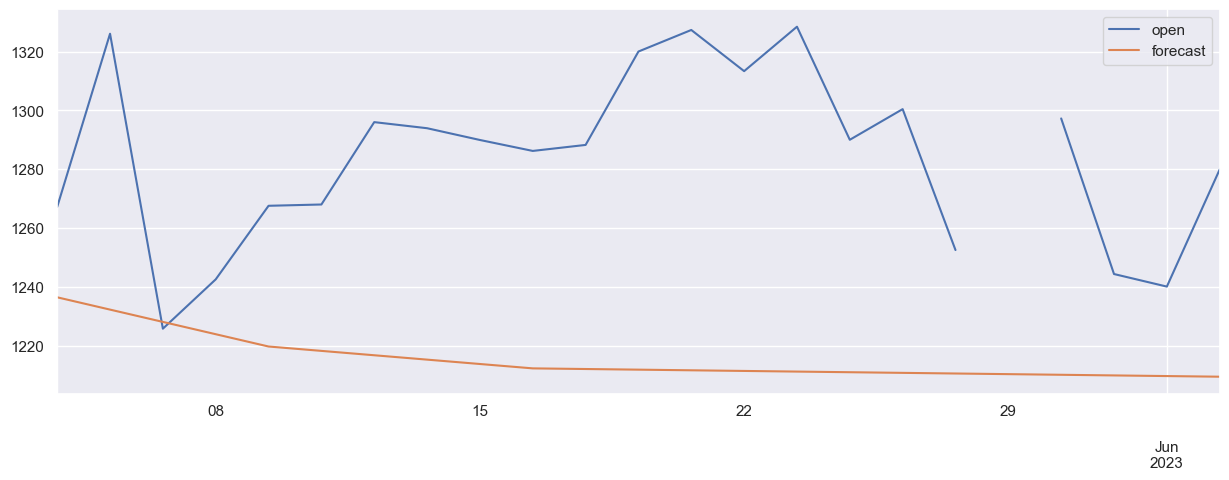

In [19]:
ds_train_forecast = ds_train.iloc[-23: -1]['open']
ds_train_forecast = pd.concat([ ds_train_forecast , ds_pred_interpolate ], axis = 1)

fig, ax = plt.subplots(1, figsize=(15,5))
ds_train_forecast.plot(ax=ax)

# Evaluating Test Period

In [20]:
## Calculate predictions and predictions intervals 

y_pred_test = pipeline.predict(ds_test)

pred_cols=[f'pred_{t}d' for t in targets_day_periods ]

ds_test_pred = ds_test.merge( pd.DataFrame(y_pred_test, columns=pred_cols, index = ds_test.index) , how = 'left', left_index = True, right_index= True )  

for period in targets_day_periods:    
    ds_test_pred = pd.concat([ds_test_pred, compute_prediction_intervals(ds_test_pred[f'pred_{period}d'], ds_test_pred[f'target_{period}d'])  ], axis = 1)


,train_pred_1d,train_pred_5d,train_pred_10d,train_pred_23d
MAE,50.31,102.22,88.74,166.41
MAPE,0.04,0.10,0.07,0.16
MSE,2753.22,20274.24,11832.27,38708.38
RMSE,52.47,142.39,108.78,196.74
R^2,0.46,-0.50,-1.07,-0.97


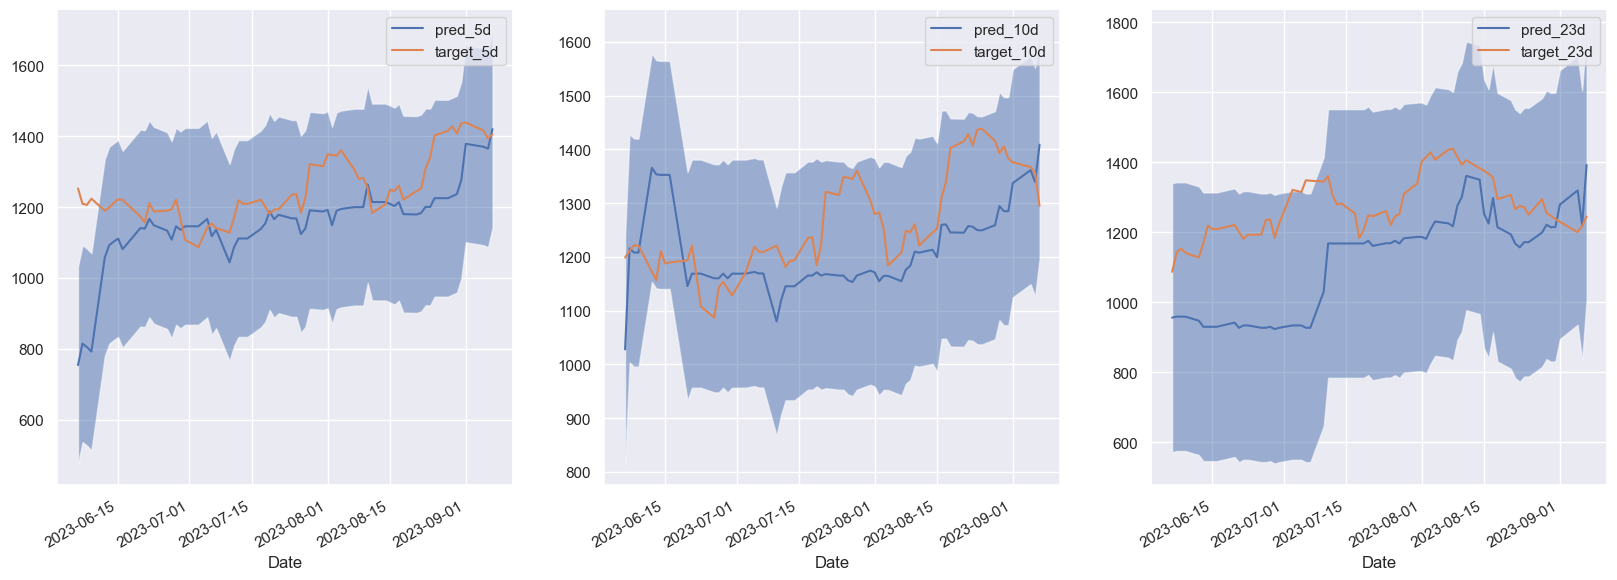

In [21]:
ds_metrics = compute_evaluation_metrics(ds_test_pred['pred_1d'], ds_test_pred['target_1d'], 'train_pred_1d')

fix, axs = plt.subplots( 1,3 , figsize = (20,7))
for idx, pred_col ,target_col in [ (0, 'pred_5d' , 'target_5d'), (1, 'pred_10d', 'target_10d')   ,(2,'pred_23d', 'target_23d') ]:
    
    ds_test_pred[[ pred_col , target_col ]].plot(ax = axs[idx] )
    axs[idx].fill_between(ds_test_pred.index, ds_test_pred[pred_col+'_upp_b'], ds_test_pred[pred_col+'_low_b'], alpha=0.5, label='Prediction Interval')
    
    ds_metrics = pd.concat( [ ds_metrics, compute_evaluation_metrics(ds_test_pred[pred_col], ds_test_pred[target_col], f'train_{pred_col}')] , axis = 1)
    
display(ds_metrics)    

# Save Test Prediction Intervals for each forecast period

In [100]:
# Compute prediction Standar Error (RMSE) with test set

forecast_se = []
for t in targets_day_periods:
    se = round(np.sqrt(mean_squared_error( ds_test_pred[f'target_{t}d'] , ds_test_pred[f'pred_{t}d']) ),2)
    forecast_se.append(se)
    

ds_se_interpolate = interpolate_prediction_days(np.array(forecast_se),
                                                dt_eval_idx,
                                                targets_day_periods).rename(
                                                    columns={'forecast':'pred_standar_error'})
ds_se_interpolate['index'] = [f'pred_{t}d' for t in range(1, day_period+1)]
ds_se_interpolate.set_index('index', inplace=True)

pickle.dump( ds_se_interpolate , open("xgb_meli_stadar_error_2023-10-15.pkl", "wb"))

### Visualizing Test prediction Errors 

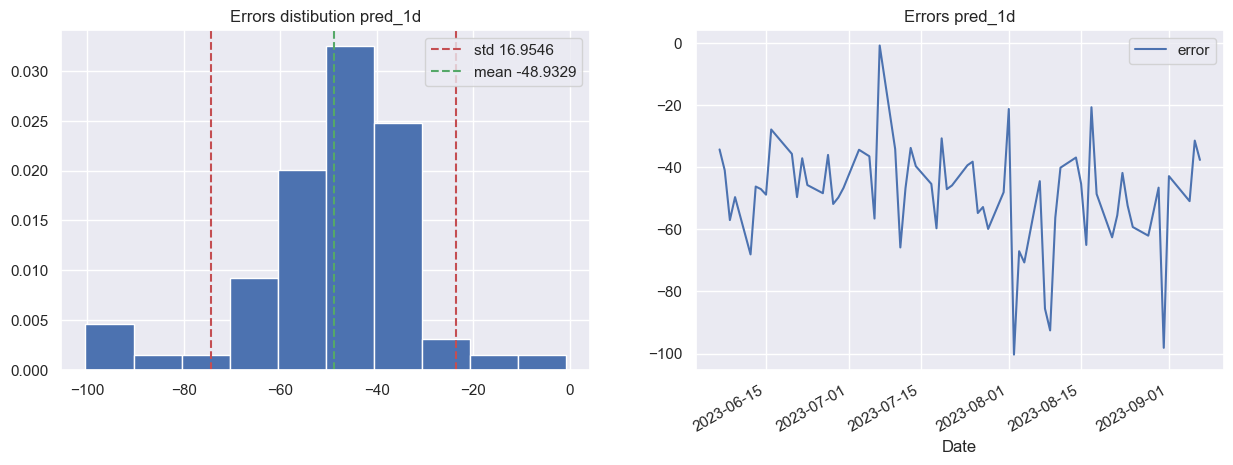

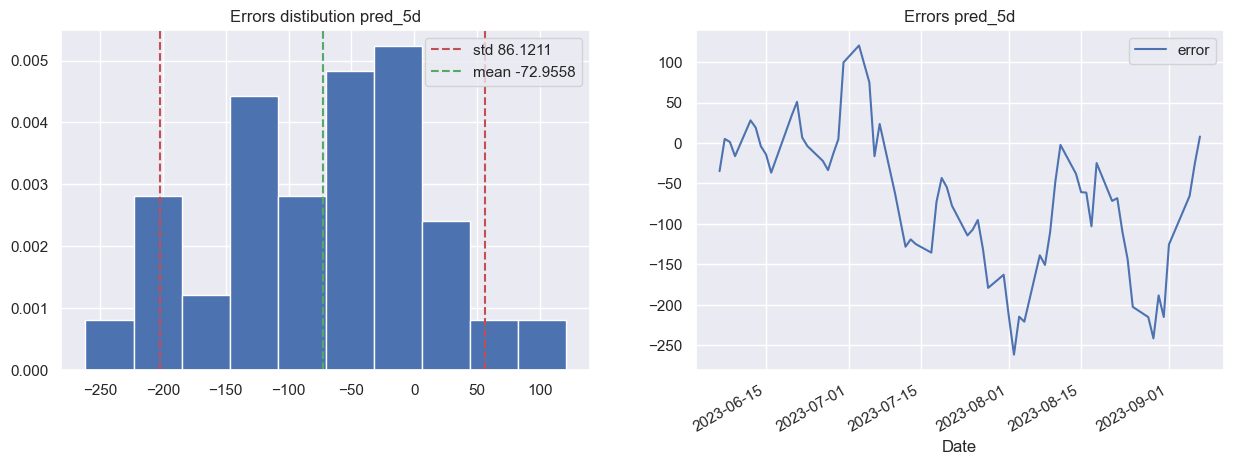

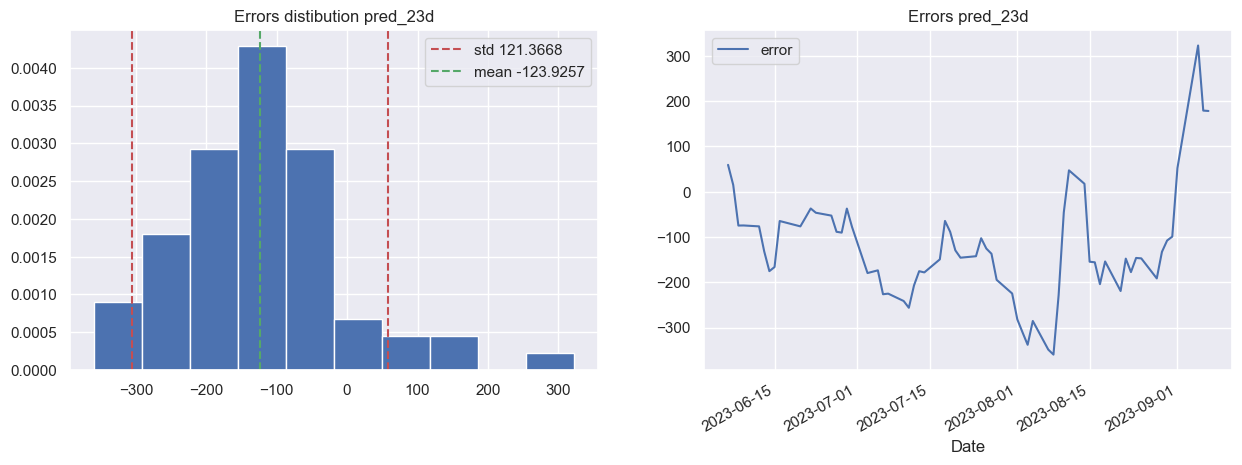

In [101]:
plot_prediction_errors(ds_test_pred['pred_1d'], ds_test_pred['target_1d'], 'pred_1d')
plot_prediction_errors(ds_test_pred['pred_5d'], ds_test_pred['target_5d'], 'pred_5d')
plot_prediction_errors(ds_test_pred['pred_23d'], ds_test_pred['target_23d'], 'pred_23d')

# Evaluating Eval Period

## Forecast the last 23 days in Eval period

In [22]:
# pipeline = pickle.load(open("xgb_pipeline_MELI_10-15.dat", "rb"))

/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1495: FutureWarning: Per

,eval_metrics
MAE,293.39
MAPE,0.30
MSE,97228.80
RMSE,311.82
R^2,-9.55


/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/ticker.py:216: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return [self(value, i) for i, value in enumerate(values)]


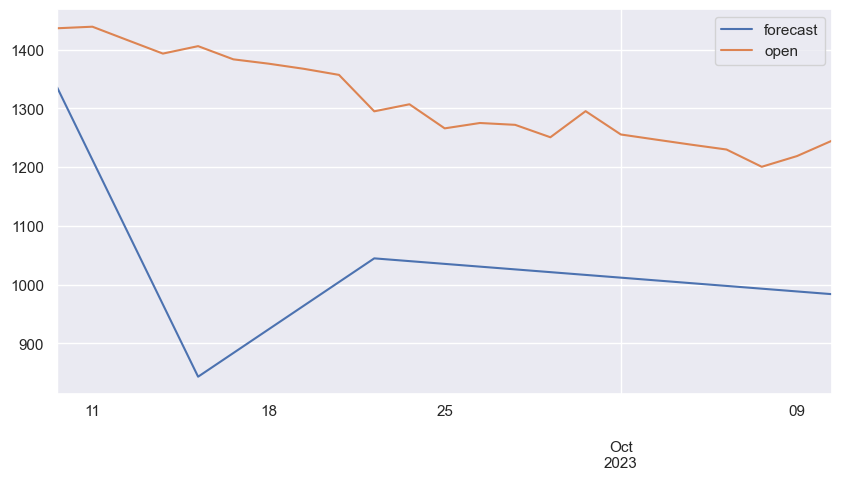

In [23]:
y_pred_eval = pipeline.predict(ds_eval)

dt_eval_idx = splitter.get_eval_idx()

ds_eval_interpolate = interpolate_prediction_days(y_pred_eval[:1, :y_pred_eval.shape[0]], dt_eval_idx, targets_day_periods)
ds_eval_forecast = pd.concat([ds_eval['open'], ds_forecast['open']], axis=0)
ds_eval_forecast = pd.concat([ds_eval_forecast, ds_eval_interpolate], axis=1)


#forecast_se = pd.read_pickle('xgb_meli_stadar_error_2023-10-15.pkl').to_numpy()
#ds_eval_forecast = pd.concat([ds_eval_forecast, compute_prediction_intervals(ds_eval_forecast.forecast, ds_eval_forecast.open, se=forecast_se.T[0] )], axis=1 )
ds_eval_forecast = ds_eval_forecast.astype(float)

fix, axs = plt.subplots( 1 , figsize = (10,5))

ds_eval_forecast[['forecast', 'open']].plot( ax = axs)
#axs.fill_between(ds_eval_forecast.index, ds_eval_forecast['forecast_upp_b'], ds_eval_forecast['forecast_low_b'], alpha=0.5, label='Prediction Interval')

compute_evaluation_metrics(ds_eval_forecast.forecast, ds_eval_forecast.open, 'eval_metrics')

### Visualizing Eval prediction Errors 

/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return self.major.locator()
/Users/ropereira/Desktop/Projects/stock_forecast/.venv/lib/python3.11/site-packages/matplotlib/axis.py:1495: FutureWarning: PeriodDtype[B] i

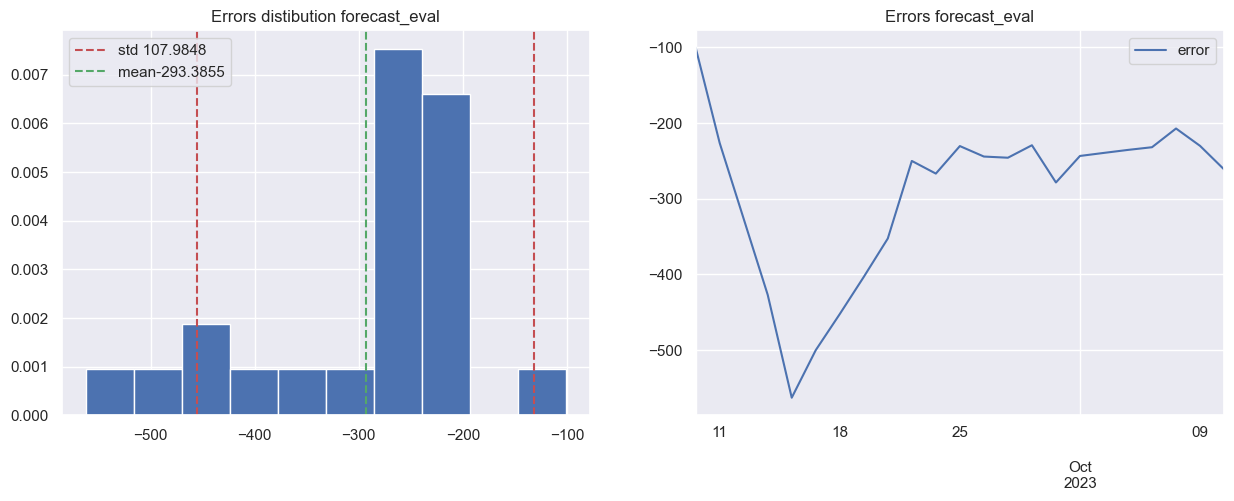

In [26]:
plot_prediction_errors(ds_eval_forecast['forecast'], ds_eval_forecast['open'], 'forecast_eval')

# Forecasting the next 23 days

In [ ]:
da = pd.concat([ds_eval, ds_forecast], axis=0)
pred_cols=  [f'pred_{t}d' for t in [1, 5, 10, 23] ]
y_pred_forecast = pd.DataFrame(pipeline.predict(da), index=da.index, columns=pred_cols)

y_pred_forecast.loc[['2023-10-10']]

In [26]:

y_pred_forecast = pipeline.predict(ds_forecast)

dt_forecast_idx = splitter.get_forecast_idx()

ds_forecast_interpolate = interpolate_prediction_days(y_pred_forecast[0], dt_forecast_idx, targets_day_periods)

#forecast_se = pd.read_pickle('xgb_meli_stadar_error_2023-10-15.pkl').to_numpy()
#ds_forecast_result = pd.concat([ds_forecast_interpolate, compute_prediction_intervals(ds_forecast_interpolate.forecast, None, se=forecast_se.T[0] )], axis=1 )
ds_forecast_result = ds_data['2022-06-01':][['close', 'open']]
ds_forecast_result = pd.concat([ds_forecast_result, ds_forecast_interpolate], axis=1)


ds_forecast_result = ds_forecast_result.astype(float)
fig, axs = plt.subplots( 1, figsize = (15,7))

ds_forecast_result[['open','forecast']].plot( ax = axs)
#axs.fill_between(ds_forecast_result.index, ds_forecast_result['forecast_upp_b'], ds_forecast_result['forecast_low_b'], alpha=0.5, label='Prediction Interval')


NameError: name 'targets_day_periods' is not defined

In [119]:
#pickle.dump( ds_forecast_result  , open("xgb_meli_ds_forecast_2023-10-15.pkl", "wb"))

## Update new days

In [33]:
from src.services import loaderclass

loader = loaderclass.StockLoader('MELI')

startdate = dt.datetime(2023,1,1)
enddate = dt.datetime(2023,12,1)

df_update = loader.load_stock(startdate, enddate)

df_update.columns = df_update.columns.str.lower()
df_update.head()

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj close,volume
Date,,,,,,
2023-01-03,867.580017,874.059998,815.859985,826.109985,826.109985,775500
2023-01-04,842.000000,849.289978,821.979980,837.440002,837.440002,404900
2023-01-05,827.869995,859.960022,818.010010,856.090027,856.090027,415200
2023-01-06,856.090027,879.419983,847.010010,873.469971,873.469971,343000
2023-01-09,891.260010,920.000000,882.000000,897.309998,897.309998,451800


In [34]:
#ds_forecast_result = pd.read_pickle('xgb_meli_ds_forecast_2023-10-15.pkl')
#ds_forecast_result

#df_update = pd.concat([df_update , ds_forecast_result[['forecast', 'forecast_upp_b','forecast_low_b' ]]] , axis = 1 )
df_update = pd.concat([df_update , ds_forecast_result['forecast']] , axis = 1 )

In [35]:
df_update

,open,high,low,close,adj close,volume,forecast
2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-11-03,NaN,NaN,NaN,NaN,NaN,NaN,1184.300941
2023-11-06,NaN,NaN,NaN,NaN,NaN,NaN,1179.738554
2023-11-07,NaN,NaN,NaN,NaN,NaN,NaN,1175.176166
2023-11-08,NaN,NaN,NaN,NaN,NaN,NaN,1170.613779


<Axes: >

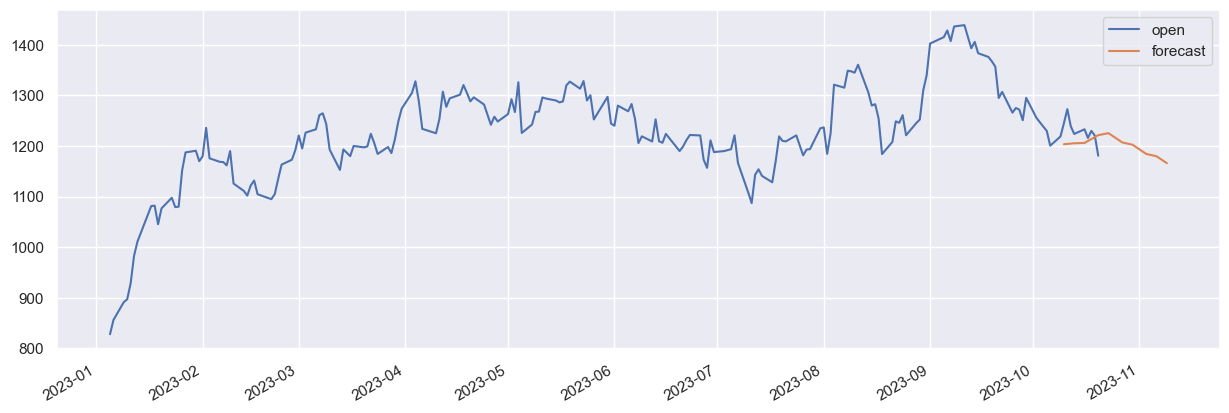

In [36]:
fig, axs = plt.subplots( 1, figsize = (15,5))

df_update['2023-01-05':][['open', 'forecast']].plot( ax = axs)
#axs.fill_between(df_update.index, df_update['forecast_upp_b'], df_update['forecast_low_b'], alpha=0.5, label='Prediction Interval')
